# Diffusion in 1D cylindrical mesh. Analytic and PyFVTool

MW 230817, 240503

This example will use Scipy to evaluate the analytic solution for a heat transfer problem, and PyFVTool to solve the same problem by the finite-volume method.

### To do
- Add the mathematical formulation of the problem

In [1]:
import numpy as np
from numpy import exp
from scipy.special import jn_zeros, j0, j1
import matplotlib.pyplot as plt

In [2]:
# explicity import all required routines from pyfvtool
from pyfvtool import CylindricalGrid1D
from pyfvtool import CellVariable
from pyfvtool import transientTerm, diffusionTerm
from pyfvtool import harmonicMean
from pyfvtool import solvePDE

## Introduction

A cylindrical object having a certain radius and infinite length has a homogeneous initial temperature (or concentration distribution if we are modeling mass transfer). At $t = 0$ it is put into perfect contact with a reservoir providing a higher temperature (or concentration). How does the temperature (concentration) profile evolve inside the cylinder over time? How long for equilibrium at the new temperature?

This could model, for instance, the initial step of cooking dry spaghetti, when the spaghetti is immersed in the boiling water, and it rapidly heats up from ambient temperature to the water temperature. The estimated duration for this step to complete is approximately 20 seconds, which makes the (still) dry spaghetti flexible enough so that it can be bent to fit into the pan (no, we do not break the spaghetti before putting it into the pan). The actual cooking process (starch gelatinization) can then start, which takes more time (don't overdo it - use a timer. Oh, and by the way, when water boils, it boils. Once the water is boiling, you can turn down the heat such that you get a gentle, steady boil. Any more heat power does not cook your spaghetti any faster.).

## Analytic solution

See:
J. Crank (1975) "The Mathematics of Diffusion", 2nd Ed., 
Clarendon Press (Oxford), p. 78, section 5.3.

Equation (5.22) reads

$$
\frac{C-C_1}{C_0-C_1} = 1 - \frac{2}{a}
\sum_{n=1}^{\infty} \frac{\exp(-D\alpha_n^2 t) J_0(r\alpha_n)}
{\alpha_n J_1(a\alpha_n)}
$$


Here we will evaluate and plot this equation.

In [3]:
def crank522(r, t, a, D):
    '''evaluate eqn 5.22 for a given r,t
    a : radius of cylinder
    D : diffusion coefficient
    
    the following global variables need to be set

    Nterm_crank : number of terms to be evaluated
    '''
    global Nterm_crank
    
    aalp = jn_zeros(0, Nterm_crank)
    alpha = aalp/a
    
    XJ0 = exp(-D * alpha**2 * t) * j0(r*alpha)
    AJ1 = alpha * j1(aalp)
    
    S = np.sum(XJ0/AJ1)
    
    return 1.0 - (2.0/a) * S

In [4]:
# set world parameters
a_val = 2.9
D_val = 1.9
Nterm_crank = 30

In [5]:
# create radial axis for plotting analytic solution
r_an = np.linspace(0.,a_val,200)

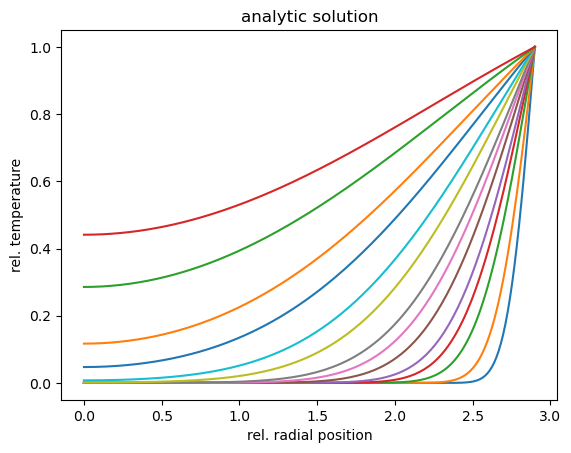

In [6]:
# evaluate crank522 at different points in time, and plot
for t in [0.005, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.15,
          0.2, 0.3, 0.4, 0.6, 0.8]:
    c = np.array([crank522(rr, t, a_val, D_val) for rr in r_an])
    plt.plot(r_an, c)
plt.xlabel('rel. radial position')
plt.ylabel('rel. temperature')
plt.title('analytic solution')
plt.show()

## Finite-volume solution with PyFVTool

Define 1D cylindrical grid with a variable called 'c', initialized to an initial value of 0.0 everywhere.

In [7]:
Nr = 50
Lr = a_val
c_outer = 1.0 # (outer) boundary concentration
c0 = 0.0
deltat = 0.001

In [8]:
mesh = CylindricalGrid1D(Nr, Lr)

Create a cell variable for the solution, initialized to value `c0`.

In [9]:
c = CellVariable(mesh, c0)

By default, the boundary conditions for a variable are of the 'no flux' (Neumann) type.

Here, we apply a different boundary condition: the outer (rightmost) boundary will be kept at 1.0 (Dirichlet boundary condition).

In [10]:
# switch the right (=outer) boundary to Dirichlet: fixed concentration
c.BCs.right.a[:] = 0.0
c.BCs.right.b[:] = 1.0
c.BCs.right.c[:] = c_outer

When changing the BCs, it is necessary to update everything in the cell variable object by calling `apply_BCs()`

In [11]:
c.apply_BCs()

In [12]:
D = CellVariable(mesh, D_val) # diffusion coefficient
alfa = CellVariable(mesh, 1.0) # transientterm coefficient

In [13]:
t = 0.0

Now, we solve the equation by taking time steps. We plot the solution at several specified time-points, together with the analytic solution.

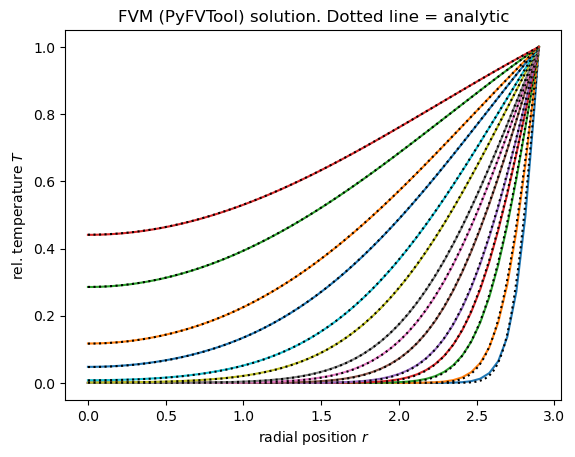

In [14]:
r_an = np.linspace(0., a_val,200) # axis for plotting analytic solution

sample_i = [5,10,20,30,40,60,80,100,150,200,300,400,600,800]

for i in range(0,1001):
    if i in sample_i:
        r, phi = c.plotprofile()
        plt.plot(r, phi)
        c_an = np.array([crank522(rr,t,a_val,D_val) for rr in r_an])
        plt.plot(r_an,c_an, 'k:')
    # calculate the value of D at the faces 
    # as the harmonic mean of the values at the centers
    Dave = harmonicMean(D)
    solvePDE(c,
             [ transientTerm(c, deltat, alfa),
              -diffusionTerm(Dave)])
    t += deltat
plt.xlabel('radial position $r$')
plt.ylabel('rel. temperature $T$')
plt.title('FVM (PyFVTool) solution. Dotted line = analytic');

## Quantitative benchmark of numerical result vs analytic solution

This is a simple, non-exhaustive benchmark. It will, however, detect if the numerical result differs significantly which will be indicative of errors in the numerical scheme.

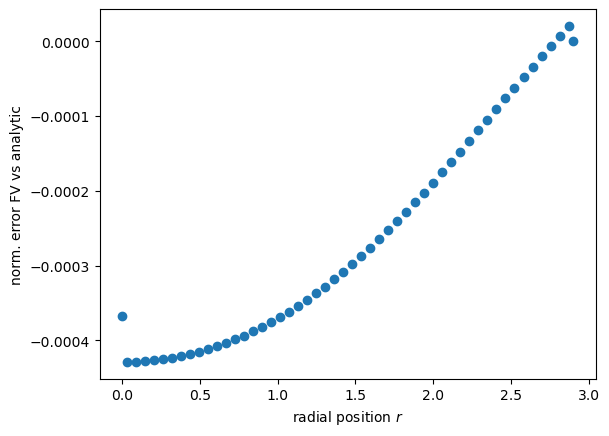

In [15]:
r_num, phi_num = c.plotprofile()
phi_an_r_num = np.array([crank522(rr, t, a_val, D_val) for rr in r_num])
norm_err = (phi_num - phi_an_r_num)/phi_an_r_num.max()
plt.plot(r_num, norm_err, 'o')
plt.xlabel('radial position $r$')
plt.ylabel('norm. error FV vs analytic');

In [16]:
# This assert will help `pytest` detect calculation errors introduced with code changes
# It is also a basic benchmark test for correct function of PyFVTool
assert np.all(np.abs(norm_err) < 0.0005)